In [2]:
import nbimporter # to import methods from another notebook
import manta_file_processing as mfp
import numpy as np
import pandas as pd
from PIL import Image
import scipy
from matplotlib import pyplot as plt
import time, random, os

from data_gen_process import image_heatmap_worker,create_datapoint


In [3]:
heatmap_order=("left-eye","right-eye","left-gill","right-gill","tail")
image_size=[100]*2

In [4]:
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense,Conv2DTranspose
from tensorflow.python.keras.layers import BatchNormalization,AveragePooling2D,Activation
from tensorflow.python.keras.callbacks import EarlyStopping

from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam

In [5]:
#pip install h5py
#pip install cython
#restart jupyther
import copy
input_shape=copy.copy(image_size)
input_shape.append(3)
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)
vgg16_net.trainable = False

In [7]:
from tensorflow.keras.models import Model

feature_extractor = Model(vgg16_net.get_input_at(0), vgg16_net.layers[17].get_output_at(0))
feature_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [8]:
model=Sequential()

input_shape=feature_extractor.layers[-1].output_shape[1:]

model.add(BatchNormalization(input_shape=input_shape))

model.add(Conv2DTranspose(filters=256,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=128,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=64,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=32,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=16,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=8,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=5,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Activation('sigmoid'))

heatmap_size=model.layers[-1].output_shape[1:3]
args=(image_size,heatmap_size,heatmap_order)
model.summary()
print("======\nHeatmap size= ",heatmap_size,"\n=====")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 6, 6, 512)         2048      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         1179904   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 10, 10, 128)       295040    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 128)       512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 21, 21, 64)        73792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 21, 21, 64)        256       
__________

In [9]:
if os.name=="nt":
    folder="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some"
else:
    folder="/tf/notebooks/data/0_manta_selected_annotated_some"
print("os = "+os.name)

print("folder: "+folder+"\n ---\ncollecting...")
dataset=mfp.get_manta_files(folder=folder)

df=dataset[dataset.body_landmark_path.isnull()==False]
#===============!!!!!!!!!!==========================
blm_min_qty=4
#===============!!!!!!!!!!==========================
print("Images with ",blm_min_qty, "or more body-landmarks are in use")
df=df[df.blm_qty>4] 

#===============!!!!!!!!!!==========================
test_mantas=["0042 Ellama",'0024 Astrea']
#==============!!!!!!!!!!!==========================
df_test=df[df.manta_name.isin(test_mantas)]
df_train=df[df.manta_name.isin(test_mantas)==False]

#validation indexes
val_ind=random.sample(list(df_train.index),len(df_train)//15)
df_val=  df_train[df_train.index.isin(val_ind)]
df_train=df_train[df_train.index.isin(val_ind)==False]

print("\nTest mantas:",test_mantas)
manta_data=np.array(df_train[["image_path","body_landmark_path"]])
print("Train Data shape=",manta_data.shape)

manta_data_val=np.array(df_val[["image_path","body_landmark_path"]])
print("Validation Data shape=",manta_data_val.shape)

manta_data_test=np.array(df_test[["image_path","body_landmark_path"]])
print("Test Data shape=",manta_data_test.shape)

os = nt
folder: C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_manta_selected_annotated_some
 ---
collecting...
total:1801
labelled:576
Labelled Individuals: 40
Images with  4 or more body-landmarks are in use

Test mantas: ['0042 Ellama', '0024 Astrea']
Train Data shape= (424, 2)
Validation Data shape= (30, 2)
Test Data shape= (31, 2)


C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_manta_selected_annotated_some\0130 Telluno\130-M-20110223-1026-LEI_MushroomBommie-LindaEarthwatch-TELLUNO-1.JPG


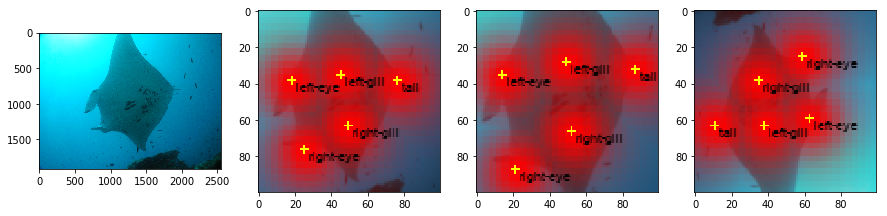

In [16]:
#check random manta and three augmentations
im_path,blm_path = manta_data[random.randint(0,manta_data.shape[0])]
image = Image.open(im_path)
print(im_path)
body_landmarks=mfp.extract_body_landmarks(blm_path)
heatmaps=mfp.gen_heatmaps(body_landmarks,heatmap_size)

fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(15, 15))
axes[0].imshow(image)

for i in range(3):
    img,hm=create_datapoint((im_path,blm_path,*args))
    axes[i+1].imshow(mfp.apply_heatmaps(mfp.denormalize(img),hm))
plt.show()

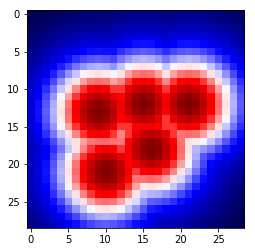

In [17]:
plt.imshow(heatmaps.max(axis=2),cmap='seismic')

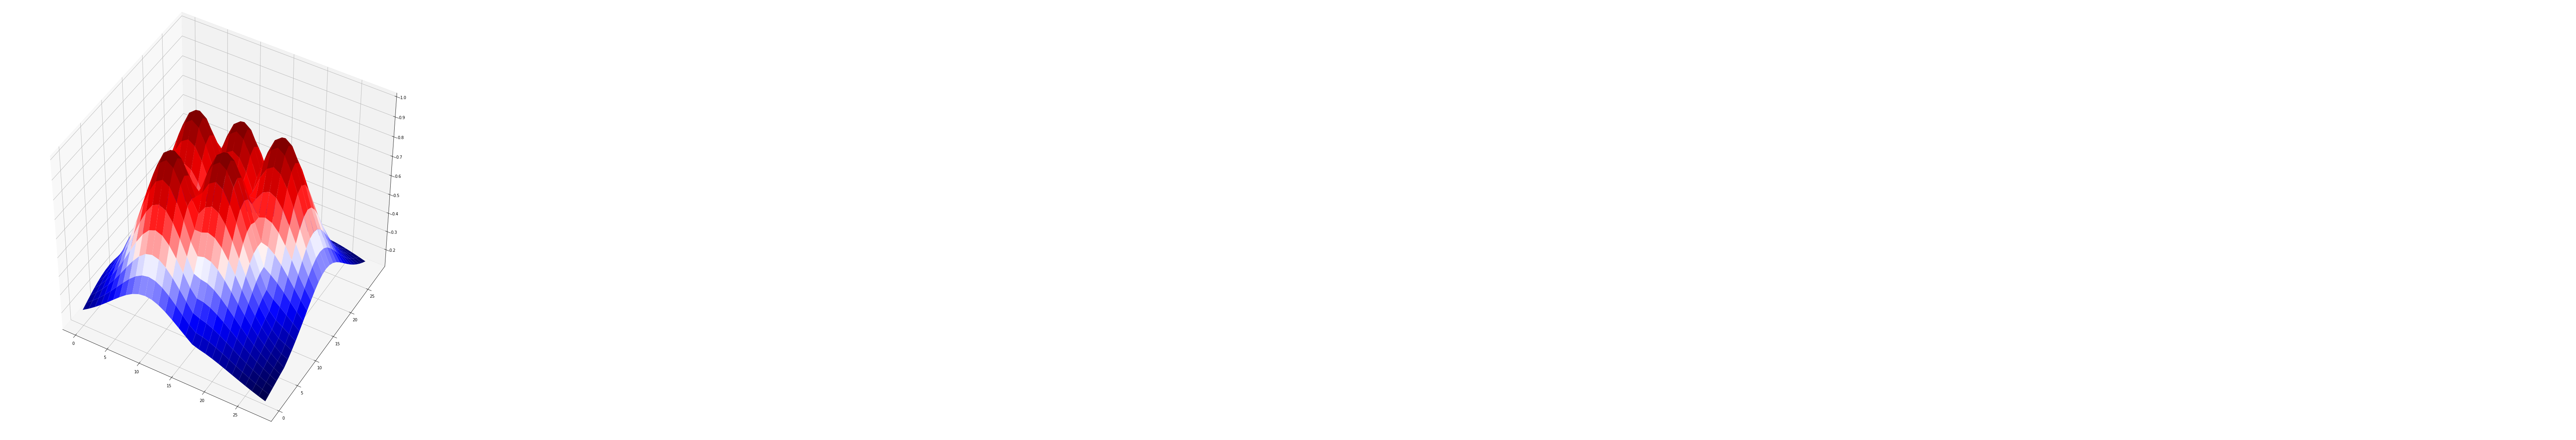

In [18]:
mfp.map3d(heatmaps.max(axis=2),alpha=45,beta=-60)

In [12]:
def plot_raw(image,body_landmarks):
    centers=[]
    for blm in body_landmarks["BLM"]:
        if blm[0] in (heatmap_order):
            centers.append(blm[1])
    centers=np.array(centers)
    xi=centers[:,0]
    yi=centers[:,1]
    plt.imshow(image)
    plt.scatter(yi,xi,color='yellow')

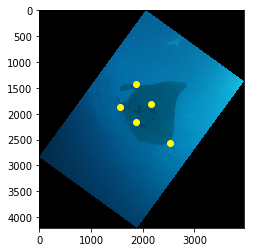

In [13]:
from scipy.ndimage import rotate
def rot(image, BLM, angle,heatmap_order):
    
    body_landmarks=copy.deepcopy(BLM)
    xy=[]
    for blm in body_landmarks["BLM"]:
        xy.append(blm[1][::-1])
    
    xy=np.array(xy)
    #print(xy)
    new_xy=[]
    
    im_rot = rotate(image,angle) 
    org_center = (np.array(image.shape[:2][::-1])-1)/2.
    rot_center = (np.array(im_rot.shape[:2][::-1])-1)/2.
    a = np.deg2rad(angle)
    
    for coord in xy:
        org = coord-org_center
        new = np.array([org[0]*np.cos(a) + org[1]*np.sin(a),
            -org[0]*np.sin(a) + org[1]*np.cos(a) ])
        new_xy.append(new)
      
    new_blm=[]
    for i,blm in enumerate(body_landmarks["BLM"]):
        if blm[0] in (heatmap_order):
            nblm=[blm[0],(new_xy[i]+rot_center)[::-1],blm[2]]
            new_blm.append(nblm)
    
    new_xy=np.array(new_xy)  
    body_landmarks["BLM"]=new_blm
    return im_rot, body_landmarks
#======demo===========
ir,b=rot(np.array(image),body_landmarks,random.randint(0,90),heatmap_order)
plot_raw(ir,b)

rotation is allowed angle= 35


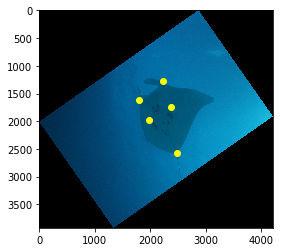

In [14]:
def rotate_image(image,BLM,heatmap_order,rs=None,verbose=False):
    
    if rs==None: rs=random.random()
        
    centers=[]
    body_landmarks=copy.deepcopy(BLM)
    for blm in body_landmarks["BLM"]:
        if blm[0] in (heatmap_order):
            centers.append(blm[1])
    centers=np.array(centers)

    mins=centers.min(axis=0)
    maxes=centers.max(axis=0)
    
    #set minimal border around landmarks
    min_area=maxes-mins
    delta=min_area*0.15
    mins=mins-delta
    maxes=maxes+delta
    mins=mins.astype('int')
    maxes=maxes.astype('int')
    area=maxes-mins

    heigh_width=np.array(body_landmarks["height_width"])
    #print("mins ",mins,maxes)

    if (area**2).sum()<heigh_width.min()**2:
        if verbose: print('rotation is allowed',end=" ")
        alpha=random.randint(0,90)
        if verbose: print("angle=" ,alpha)
        return rot(np.array(image),body_landmarks,alpha,heatmap_order)
    else:
        if verbose: print("rotation is not allowed")
        return image,BLM
#======demo========
ir,b=rotate_image(image,body_landmarks,heatmap_order,verbose=True)
plot_raw(ir,b)

0.9815573770491803 1


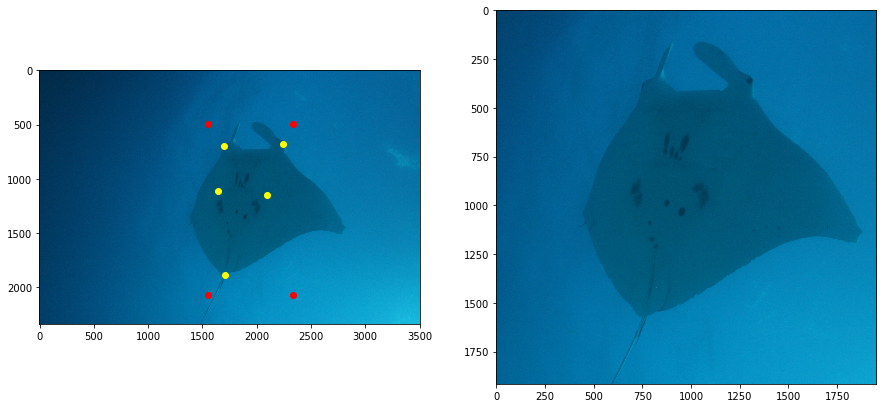

In [15]:
from data_gen_process import crop_image
#==============
centers=[]
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 15))
axes[0].imshow(image)
for blm in body_landmarks["BLM"]:
    if blm[0] in (heatmap_order):
        centers.append(blm[1])
centers=np.array(centers)
xi=centers[:,0]
yi=centers[:,1]
axes[0].scatter(yi,xi,color='yellow')

#im_rot,blm_rot=rotate_image(np.array(image),body_landmarks,heatmap_order,verbose=True)

im_cut,blm_cut,mins,maxes=crop_image(np.array(image),body_landmarks,heatmap_order,bound_box=0.15,verbose=True)

centers=[]
    
for blm in blm_cut["BLM"]:
    if blm[0] in (heatmap_order):
        centers.append(blm[1])

centers=np.array(centers)
xi=centers[:,0]
yi=centers[:,1]

y=[mins[0],mins[0],maxes[0],maxes[0]]
x=[mins[1],maxes[1],maxes[1],mins[1]]

#axes[1].imshow(im_rot)
#axes[1].scatter(yi,xi,color='yellow')
axes[0].scatter(x,y,color='red')
axes[1].imshow(im_cut)


In [16]:
def image_generator_single_thread(manta_data, image_size,heatmap_size, batch_size = 1,rs=None,verbose=True):
    if rs==None: rs=random.random()
    while True:

        # Select files (paths/indices) for the batch
        if batch_size<manta_data.shape[0]:
            batch_data = random.sample(list(manta_data),batch_size)
        else:
            batch_data=random.sample(list(manta_data),manta_data.shape[0])
            qty=batch_size-manta_data.shape[0]
            while qty>0:
                if qty<manta_data.shape[0]:
                    next_batch = random.sample(list(manta_data),qty)
                    qty=0
                else:
                    next_batch = random.sample(list(manta_data),manta_data.shape[0])
                    qty=qty-manta_data.shape[0]
                batch_data=np.vstack((batch_data,next_batch))
        
        batch_input = []
        batch_output = [] 
        batch_images=[]
        
          # Read in each input, perform preprocessing and get labels
        i=0
        for im_path,blm_path in batch_data:
            i+=1
            if verbose and i%100==0:print(i,end="")
            if verbose and i%10==0: print(".",end="")    
            image,heatmaps=create_datapoint((im_path,blm_path,image_size,heatmap_size,heatmap_order))
            
            #if image==None:
            #    pass
            #else:
            batch_input.append(image)
            batch_output.append(heatmaps)
        
        batch_x=np.array(batch_input)
        batch_y=np.array(batch_output)
           
        yield( batch_x, batch_y )  

In [17]:
def image_generator_multi_process(manta_data, image_size,heatmap_size, num_processes=2, batch_size = 1,rs=None,verbose=True):

    def flush(t=None):
        i=0
        while True:
            i+=1
            try:
                im=images_q.get(timeout=t)  
                hm=heatmaps_q.get(timeout=t)  
            except:break
            images.append(im)
            heatmaps.append(hm) 
            
        print("\n saved",i,end=" ")
#------------------------------        
        
    def gen100():
        try:
            del(images_q)
            del(heatmaps_q)
        except: pass
        images_q =ArrayQueue(15)
        images_q.clear()
        heatmaps_q =ArrayQueue(15)
        heatmaps_q.clear()

        #spawning processes
        mypool=[]
        for i in range(num_processes):
            p = mp.Process(target=image_heatmap_worker, args=(inq,images_q,heatmaps_q,l,log,params))
            p.daemon=True
            p.start()
            mypool.append(p)

        #print log   
        time.sleep(5)
        while True:
            try:
                inf=log.get()
            except:pass
            if inf==None: break
            print(inf,end="") 

        print("\n Terminating processes:",end=" ")    
        time.sleep(1)
        for p in mypool:
            p.terminate()  
            print("killed",end=" ")

        print("\n rest of log:")
        #print log    
        while True:
            try:  inf=log.get(timeout=0.5)
            except: break
            print(inf,end="")                    


        #extracting images and heatmaps from the queues
        

        flush(t=0.5)                 
        
#------------------------------        
    
    if rs==None: rs=random.random()

    while True:
        # Select files (paths/indices) for the batch
        if batch_size<manta_data.shape[0]:
            batch_data = random.sample(list(manta_data),batch_size)
        else:
            batch_data=random.sample(list(manta_data),manta_data.shape[0])
            qty=batch_size-manta_data.shape[0]
            while qty>0:
                if qty<manta_data.shape[0]:
                    next_batch = random.sample(list(manta_data),qty)
                    qty=0
                else:
                    next_batch = random.sample(list(manta_data),manta_data.shape[0])
                    qty=qty-manta_data.shape[0]
                batch_data=np.vstack((batch_data,next_batch))
        
        
        params=(image_size,heatmap_size,heatmap_order)
        
         #input queue
        images=[]
        heatmaps=[]        
        
        part_len=90
        for part in range(len(batch_data)//part_len+1):
            this_batch=batch_data[part*part_len:(part+1)*part_len]        
                
                
            inq=mp.Queue()
            for j,item in enumerate(this_batch):
                inq.put((j,list(item)))
        
        
        
            #----------------
            for t in range(num_processes+1) :
                inq.put((None,None)) # stopping points for processes

            log=mp.Queue() #log queue
            log.put("start")

            #lock just in case
            l=mp.Lock()        


            try:
                del(images_q)
                del(heatmaps_q)
            except: pass
            images_q =ArrayQueue(30)
            images_q.clear()
            heatmaps_q =ArrayQueue(30)
            heatmaps_q.clear()

            #spawning processes
            mypool=[]
            for ip in range(num_processes):
                p = mp.Process(target=image_heatmap_worker, args=(inq,images_q,heatmaps_q,l,log,params))
                p.daemon=True
                p.start()
                mypool.append(p)

            #print log   
            time.sleep(5)
            while True:
                try:
                    inf=log.get()
                except:pass
                if inf==None: break
                if inf=="FFF":
                    pass
                    #print(" flush ")
                    #time.sleep(2)
                    #l.acquire()
                    #flush()
                    #l.release()
                else:
                    print(inf,end="") 

            print("\n Terminating processes:",end=" ")    
            time.sleep(1)
            for p in mypool:
                p.terminate()  
                print("killed",end=" ")

            print("\n rest of log:")
            #print log    
            while True:
                try:  inf=log.get(timeout=0.5)
                except: break
               # print(inf,end="")                    
            flush(t=0.5)
            print("\n Current Length: ",len(images),len(heatmaps))
        #for i in range(len(batch_data)//100+1):
         #   gen100()
   
#===================================
            
        print(" converting toarray")
        images=np.array(images)
        heatmaps=np.array(heatmaps)
        print("\n===Done===")         
        yield( images,heatmaps)

In [18]:
#generator=image_generator_multi_process(manta_data,image_size,heatmap_size,batch_size=1000,num_processes=8,verbose=True)
#%%time
#pics_train,y_train=next(generator)
#print('\n',pics_train.shape,y_train.shape )

In [19]:
%%time
generator=image_generator_single_thread(manta_data,image_size,heatmap_size,batch_size=5000,verbose=True)#num_threads=2
pics_train,y_train=next(generator)
print('\n',pics_train.shape )

.........100..........200..........300..........400..........500..........600..........700..........800..........900..........1000..........1100..........1200..........1300..........1400..........1500..........1600..........1700..........1800..........1900..........2000..........2100..........2200..........2300..........2400..........2500..........2600..........2700..........2800..........2900..........3000..........3100..........3200..........3300..........3400..........3500..........3600..........3700..........3800..........3900..........4000..........4100..........4200..........4300..........4400..........4500..........4600..........4700..........4800..........4900..........5000.
 (5000, 100, 100, 3)
Wall time: 55min 46s


In [49]:
np.save("dataset_final_pics.npy",pics_train)
np.save("dataset_final_y.npy",y_train)

In [20]:
%%time
val_generator=image_generator_single_thread(manta_data_val,image_size,heatmap_size,batch_size=600,verbose=True)
pics_val,y_val=next(val_generator)
print('\n',pics_val.shape )

.........100..........200..........300..........400..........500..........600.
 (600, 100, 100, 3)
Wall time: 6min 16s


In [21]:
%%time
X_train=feature_extractor.predict(pics_train)
X_val=feature_extractor.predict(pics_val)

Wall time: 1min 55s


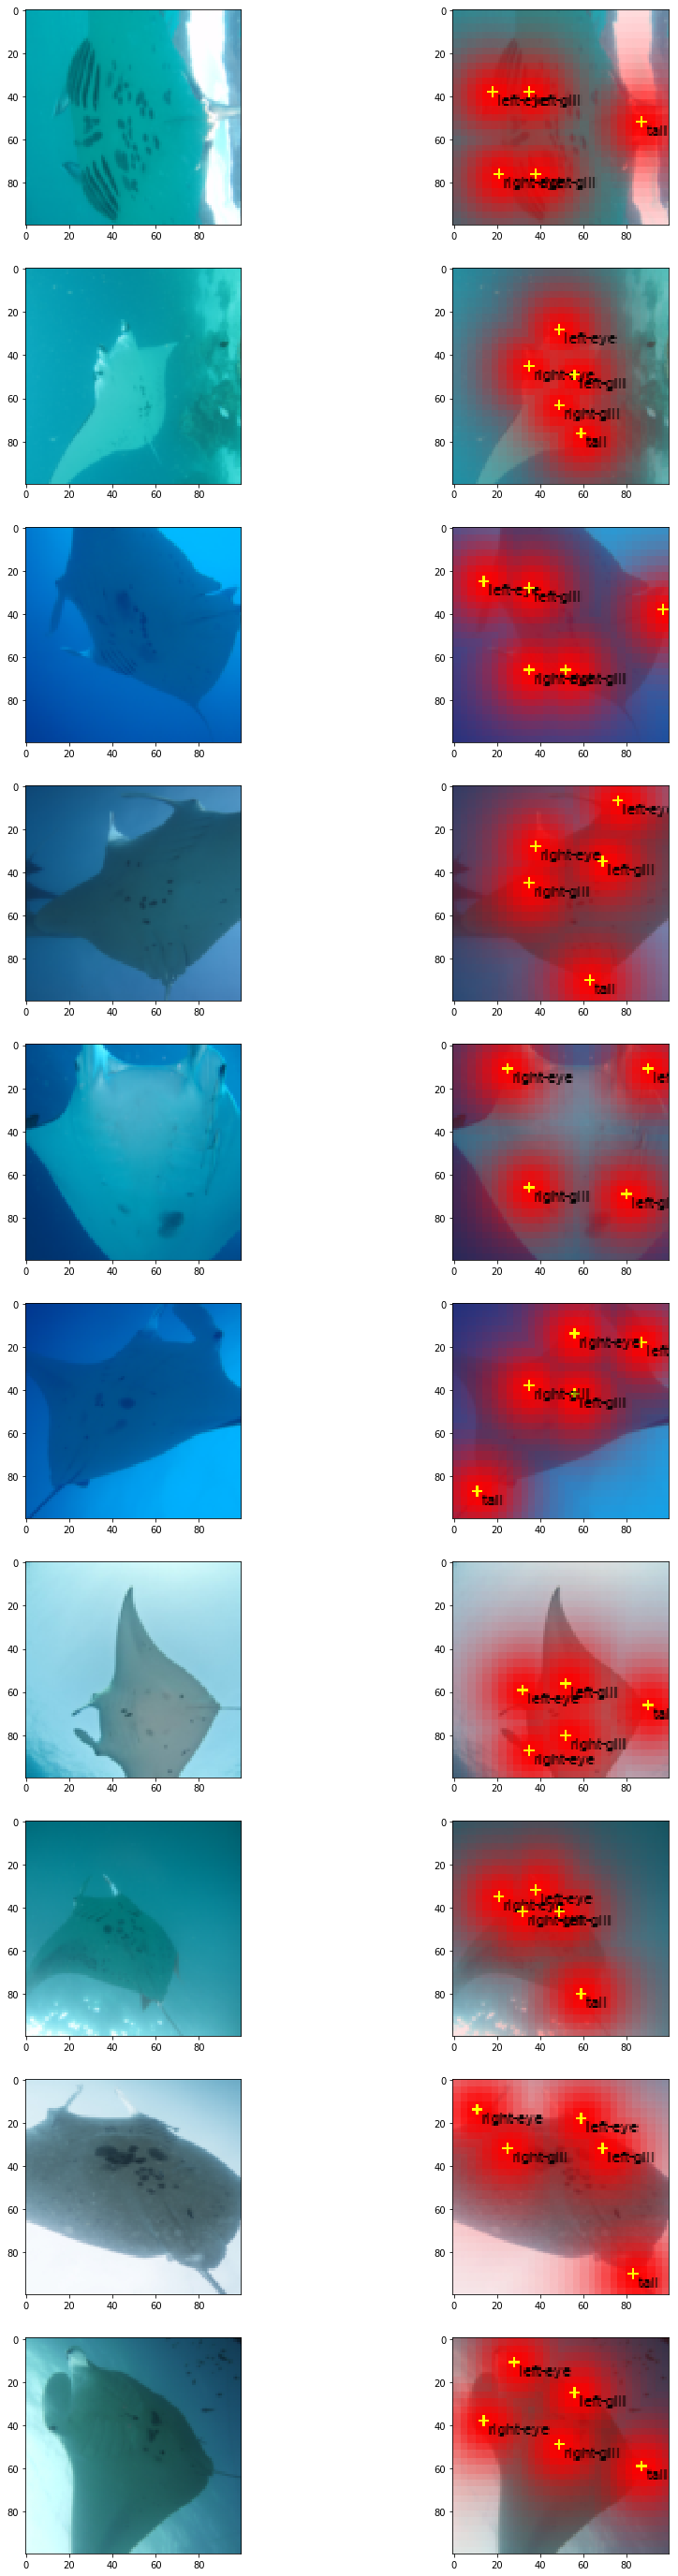

In [22]:
n=10
samples=random.sample(list(np.arange(pics_train.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=2,figsize=(15, 50))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(pics_train[s]))
    axes[i,1].imshow(mfp.apply_heatmaps(mfp.denormalize(pics_train[s]),y_train[s]))
plt.show()

In [23]:
model.compile(loss='mse',#'binary_crossentropy',
              optimizer='adam')#,
#metrics=['mse','binary_accuracy'])

In [24]:
#del model
#model=keras.models.load_model("model.h5")

In [25]:
start_time = time.time()
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

batch_size=32
init_epochs=600

history=model.fit(X_train,y_train,
                  batch_size=batch_size,
                  epochs=init_epochs,
                  validation_data=(X_val,y_val),
#                  validation_split=0.1,
                  callbacks=[early_stopping_callback])

training_time=round(time.time() - start_time,0)

Train on 5000 samples, validate on 600 samples
Epoch 1/600
5000/5000 [==============================] - 29s 6ms/step - loss: 0.0848 - val_loss: 0.0772
Epoch 2/600
5000/5000 [==============================] - 23s 5ms/step - loss: 0.0565 - val_loss: 0.0592
Epoch 3/600
5000/5000 [==============================] - 23s 5ms/step - loss: 0.0402 - val_loss: 0.0438
Epoch 4/600
5000/5000 [==============================] - 23s 5ms/step - loss: 0.0293 - val_loss: 0.0367
Epoch 5/600
5000/5000 [==============================] - 23s 5ms/step - loss: 0.0219 - val_loss: 0.0313
Epoch 6/600
5000/5000 [==============================] - 23s 5ms/step - loss: 0.0169 - val_loss: 0.0279
Epoch 7/600
5000/5000 [==============================] - 23s 5ms/step - loss: 0.0134 - val_loss: 0.0260
Epoch 8/600
5000/5000 [==============================] - 23s 5ms/step - loss: 0.0109 - val_loss: 0.0240
Epoch 9/600
5000/5000 [==============================] - 23s 5ms/step - loss: 0.0091 - val_loss: 0.0229
Epoch 10/600
5000


Training time :'--- 19.0 min 27.0 sec ---


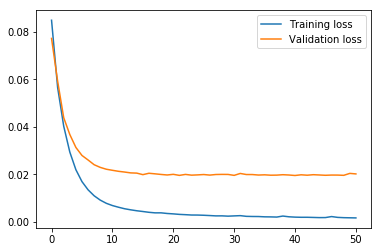

In [26]:
print("\nTraining time :'--- %s min %s sec ---" % (training_time//60,training_time%60) )
loss = history.history['loss']
val_loss= history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.show()

In [27]:
def smooth_heatmap(heatmaps,sigma=2):
    from scipy.ndimage.filters import gaussian_filter
    blured=[]
    heatmap=np.moveaxis(heatmaps,-1,0)
    for hm in heatmap:
        blured.append(gaussian_filter(hm,sigma))
    blured=np.array(blured)
    blured=np.moveaxis(blured,0,-1)
    return blured

def heatmap_error(prediction,ground_truth):
    distances=[]
    pred=np.moveaxis(prediction,-1,-0)
    gt=np.moveaxis(ground_truth,-1,-0)
    for p,g in zip(pred,gt):
        #find center of heatmap
        if gt.sum()>0:
            center=np.argmax(g)
            center_true=(center//g.shape[0],center%g.shape[1])
            
            center=np.argmax(p)
            center_pred=(center//p.shape[0],center%p.shape[1])
            
            from scipy.spatial import distance
            #print(distance.euclidean(g, p))
            distances.append(distance.euclidean(center_true, center_pred))
        else:
            distances.append(p.shape[0]*1.5)
    return np.array(distances)

In [28]:
test_gen=image_generator_single_thread(manta_data_test,image_size,heatmap_size,batch_size=50,verbose=True)
pics_test,y_test=next(test_gen)
X_test=feature_extractor.predict(pics_test)

.....

In [29]:
pred=model.predict(X_test)
smoothed=np.array([smooth_heatmap(h) for h in pred])
distances=np.array([heatmap_error(t,p).mean() for t,p in zip (smoothed,y_test)])
print(X_test.shape)
print(pred.shape)
print(smoothed.shape)

(50, 6, 6, 512)
(50, 29, 29, 5)
(50, 29, 29, 5)


In [32]:
distances=pd.DataFrame(distances)
distances.columns=['error']
distances=distances.sort_values('error')
rating=distances.index
print("mean error ",distances.error.mean())
print("standard deviation ",distances.error.std())
distances

mean error  4.169053430753876
standard deviation  2.9886921500076222


error
47   0.847214
2    0.882843
49   1.165685
27   1.412899
45   1.494427
17   1.530056
15   1.660113
9    1.686796
44   1.695742
42   1.695742
21   1.742955
39   1.824621
48   1.847214
4    1.962512
1    1.977270
46   1.986021
0    2.045355
8    2.126883
35   2.390812
25   2.588854
31   2.609725
22   2.824483
18   2.879669
41   3.001753
13   3.183861
30   3.191988
23   3.562050
36   3.798830
20   4.182997
6    4.221310
3    4.422096
14   4.519182
32   4.586995
5    4.700166
12   4.725561
38   5.239792
28   5.633018
29   5.648508
43   5.837817
34   6.013617
19   6.044088
40   6.087211
33   6.798214
11   6.985682
26   7.254369
10   8.712933
7   10.581455
37  10.763894
24  11.958086
16  13.919304

In [33]:
pics_test_new=[mfp.denormalize(p) for p in pics_test]
pics_test=pics_test_new

4.700165666547758


Text(0.5, 1.0, 'ground truth')

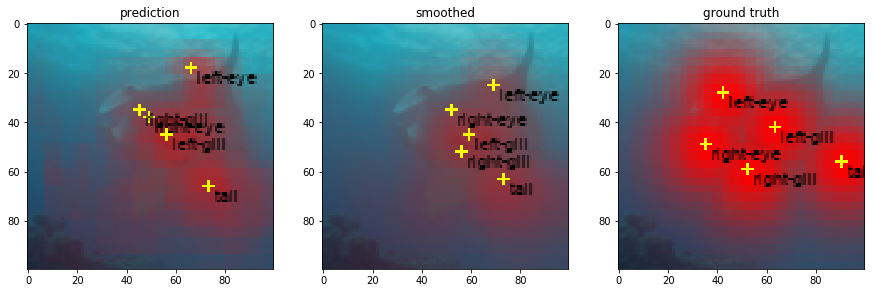

In [34]:
i=5
print(distances.error[i])
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 15))
axes[0].imshow(mfp.apply_heatmaps((pics_test[i]),pred[i]))
axes[0].set_title("prediction")
axes[1].imshow(mfp.apply_heatmaps((pics_test[i]),smoothed[i]))
axes[1].set_title("smoothed")
axes[2].imshow(mfp.apply_heatmaps((pics_test[i]),y_test[i]))
axes[2].set_title("ground truth")

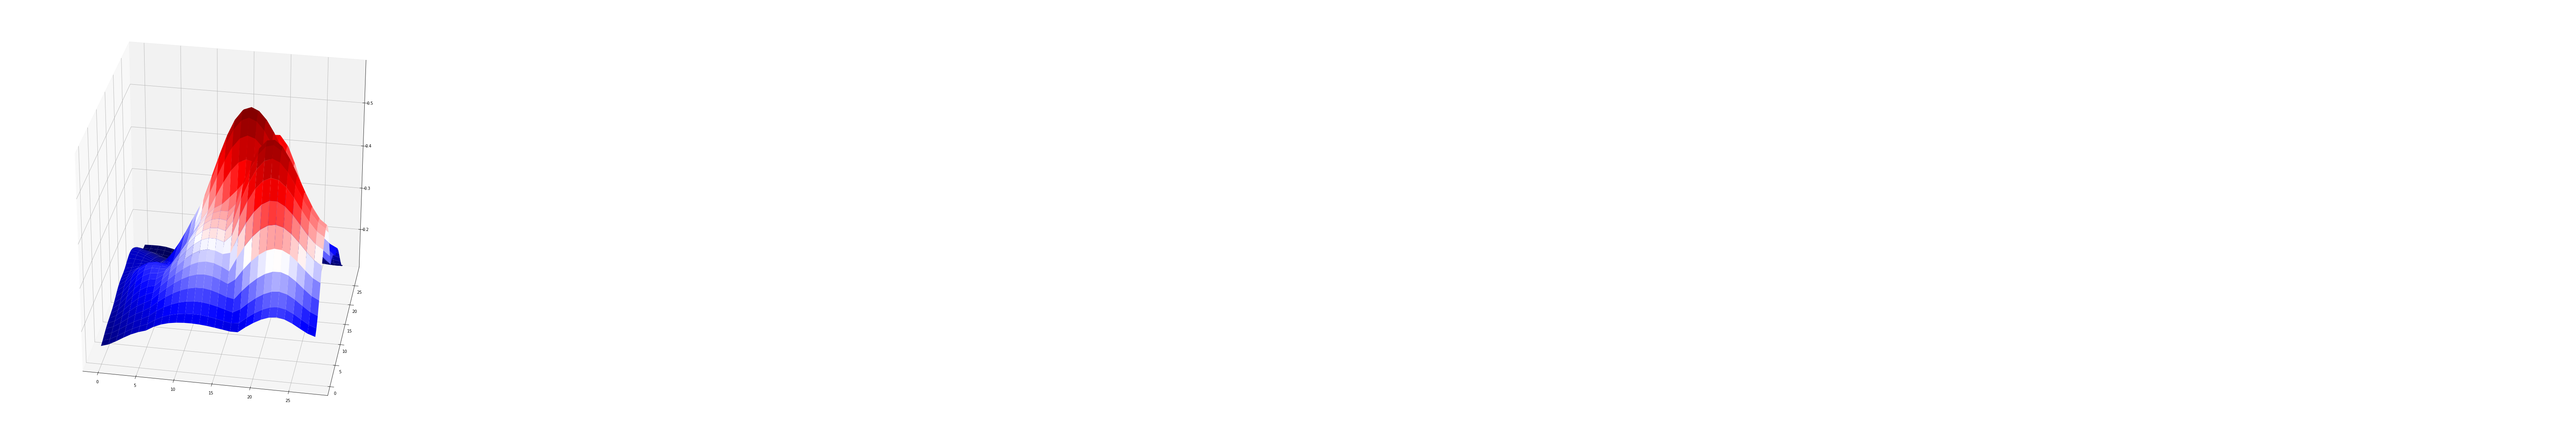

In [35]:
mfp.map3d(smoothed[i].max(axis=2),alpha=30)

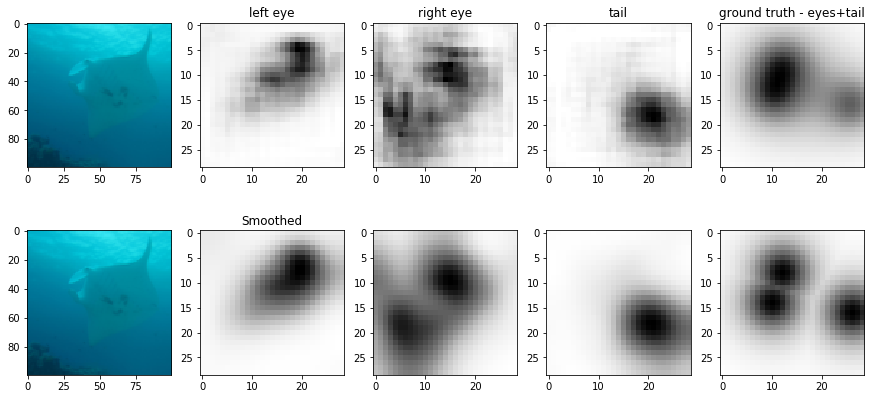

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=5,figsize=(15, 7))
axes[0,0].imshow((pics_test[i]))
axes[0,1].imshow(pred[i][:,:,0],cmap='Greys')
axes[0,1].set_title("left eye")
axes[0,2].imshow(pred[i][:,:,1],cmap='Greys')
axes[0,2].set_title("right eye")
#axes[i,3].imshow(pred[s][:,:,2],cmap='Greys')
axes[0,3].imshow(pred[i][:,:,4],cmap='Greys')
axes[0,3].set_title("tail")
axes[0,4].imshow(y_test[i][:,:,[0,1,4]].sum(axis=2),cmap='Greys')
axes[0,4].set_title("ground truth - eyes+tail")

blured=smooth_heatmap(pred[i],2)

axes[1,0].imshow((pics_test[i]))
axes[1,1].set_title("Smoothed")
axes[1,1].imshow(blured[:,:,0],cmap='Greys')
axes[1,2].imshow(blured[:,:,1],cmap='Greys')
#axes[i,3].imshow(pred[s][:,:,2],cmap='Greys')
axes[1,3].imshow(blured[:,:,4],cmap='Greys')
axes[1,4].imshow(y_test[i][:,:,[0,1,4]].max(axis=2),cmap='Greys')

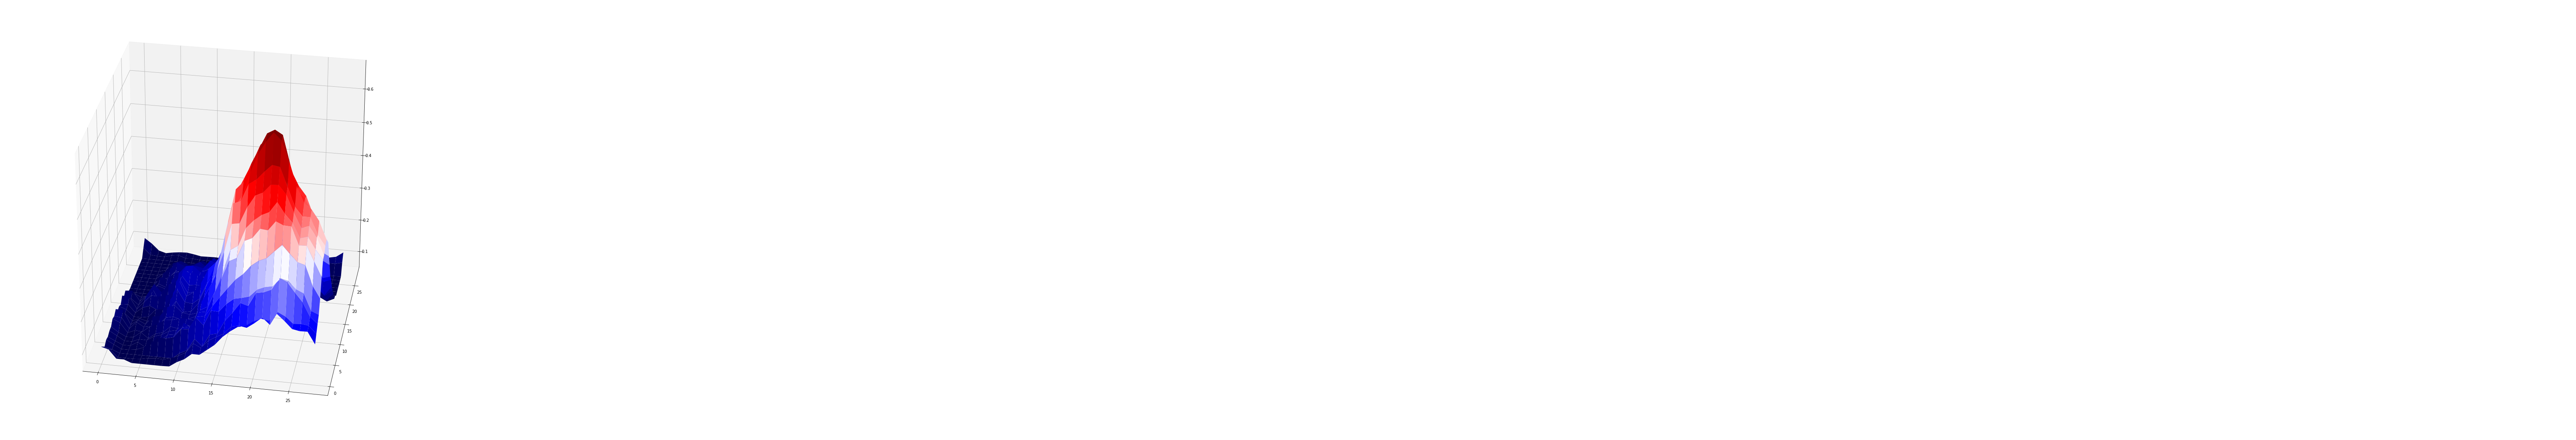

In [37]:
mfp.map3d(pred[i][:,:,4])

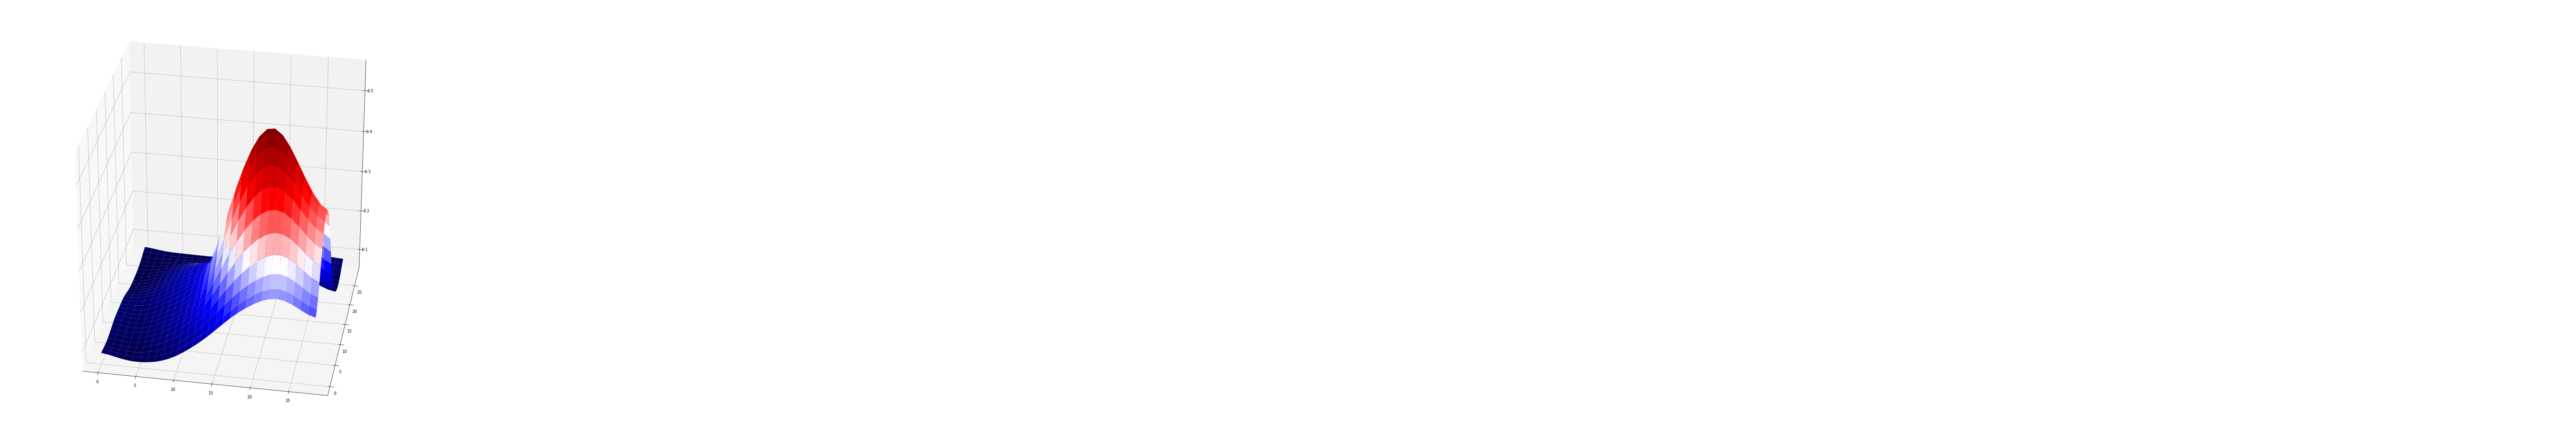

In [38]:
mfp.map3d(blured[:,:,4])

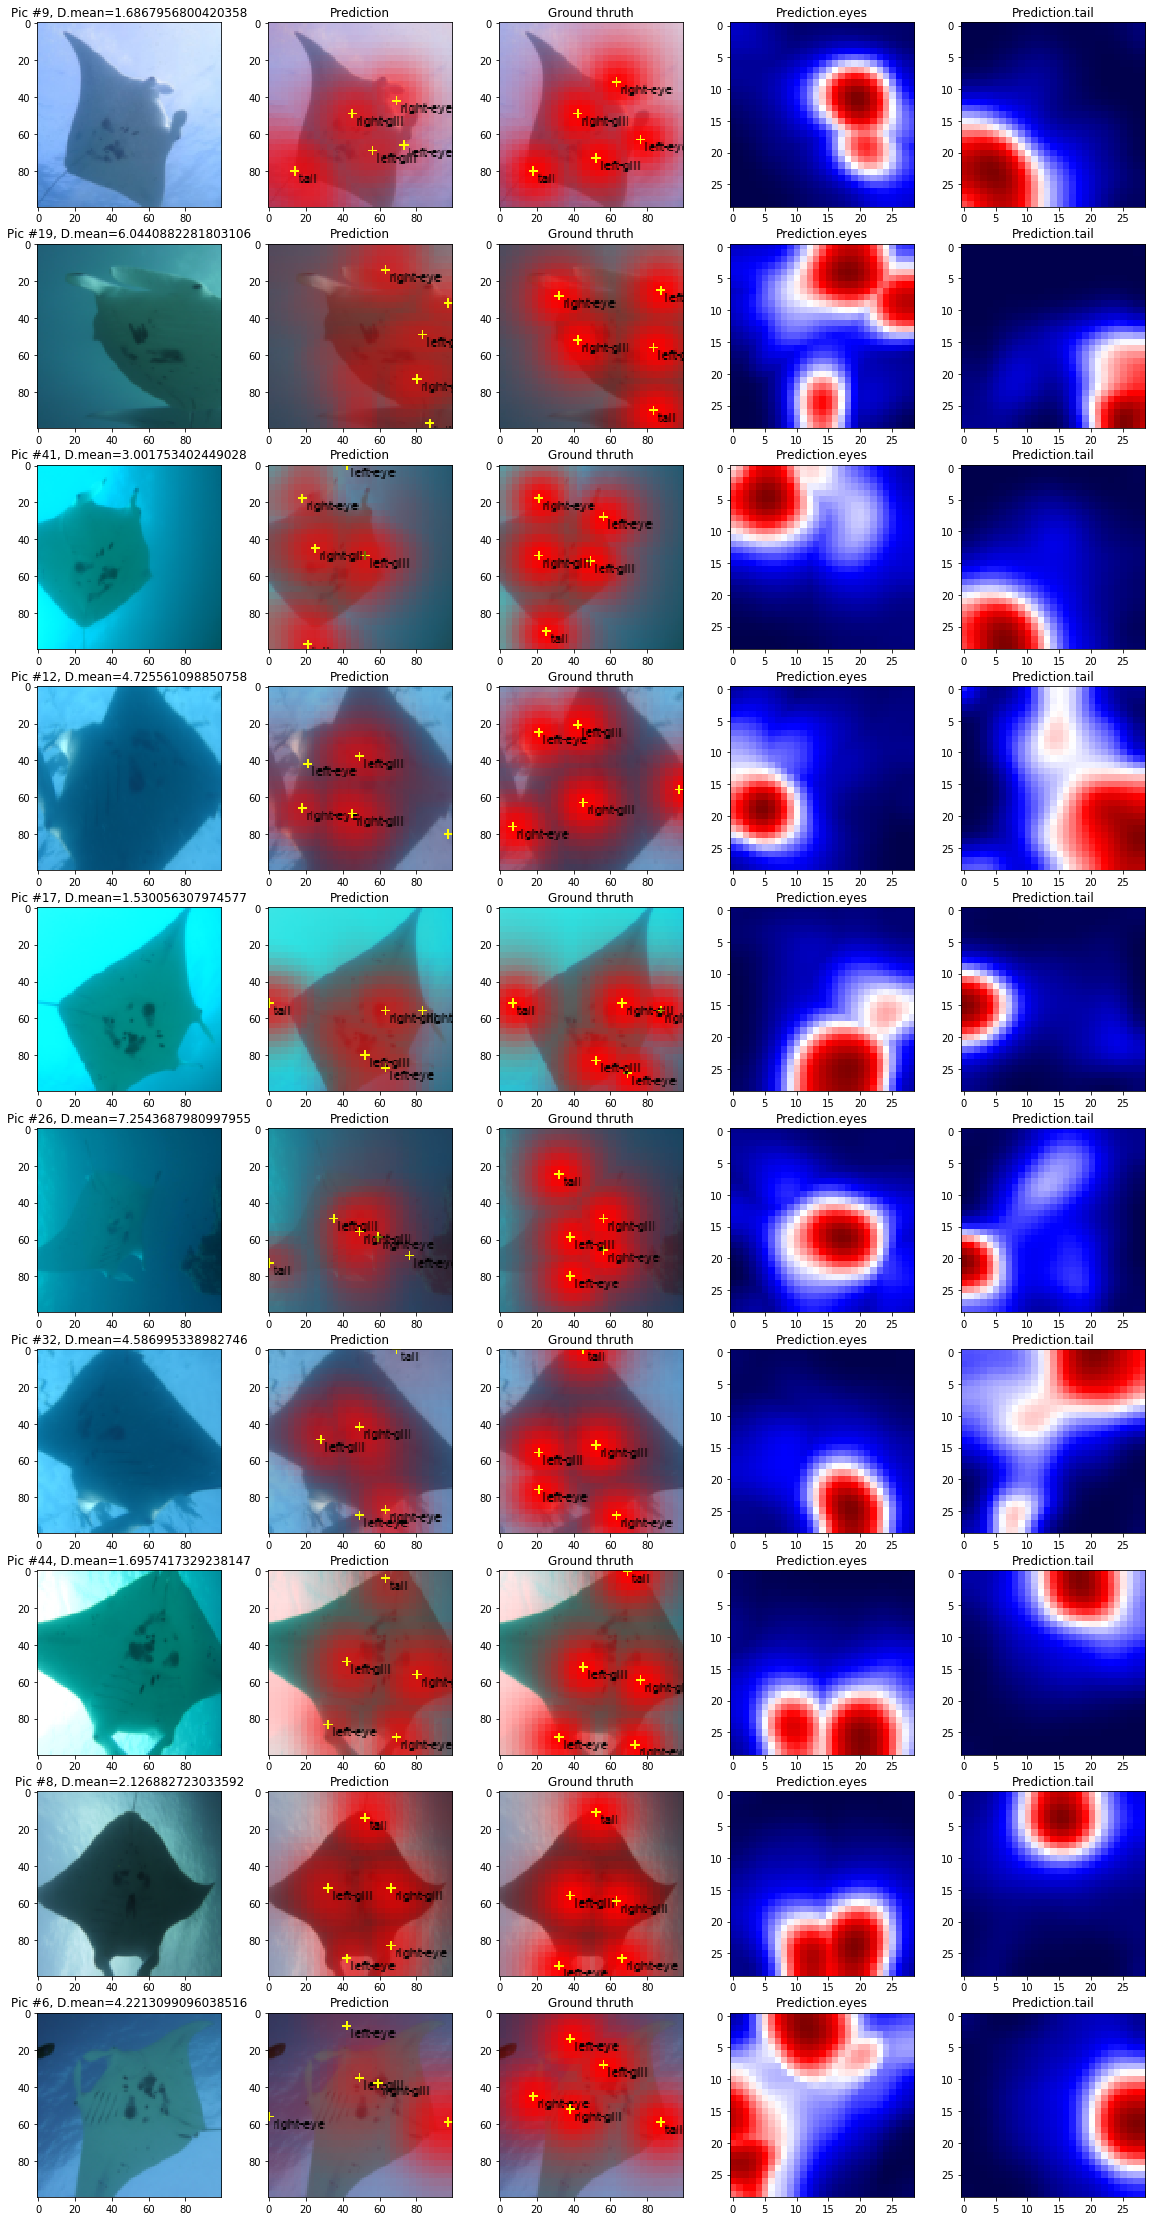

In [39]:
#random
n=10#X_test.shape[0]
samples=random.sample(list(np.arange(pred.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=5,figsize=(20, 40))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow((pics_test[s]))
    axes[i,0].set_title("Pic #"+str(samples[i])+", D.mean="+str(distances.error[samples[i]]))
    
    axes[i,1].imshow(mfp.apply_heatmaps((pics_test[s]),smoothed[s]))
    axes[i,1].set_title('Prediction')
    
    axes[i,2].imshow(mfp.apply_heatmaps((pics_test[s]),y_test[s]))
    axes[i,2].set_title('Ground thruth')
    hm=smooth_heatmap(pred[s],2)
    
    axes[i,3].imshow(hm[:,:,:2].max(axis=2),cmap='seismic')
    axes[i,3].set_title('Prediction.eyes')
    
    axes[i,4].imshow(hm[:,:,4],cmap='seismic')
    axes[i,4].set_title('Prediction.tail')


plt.show()

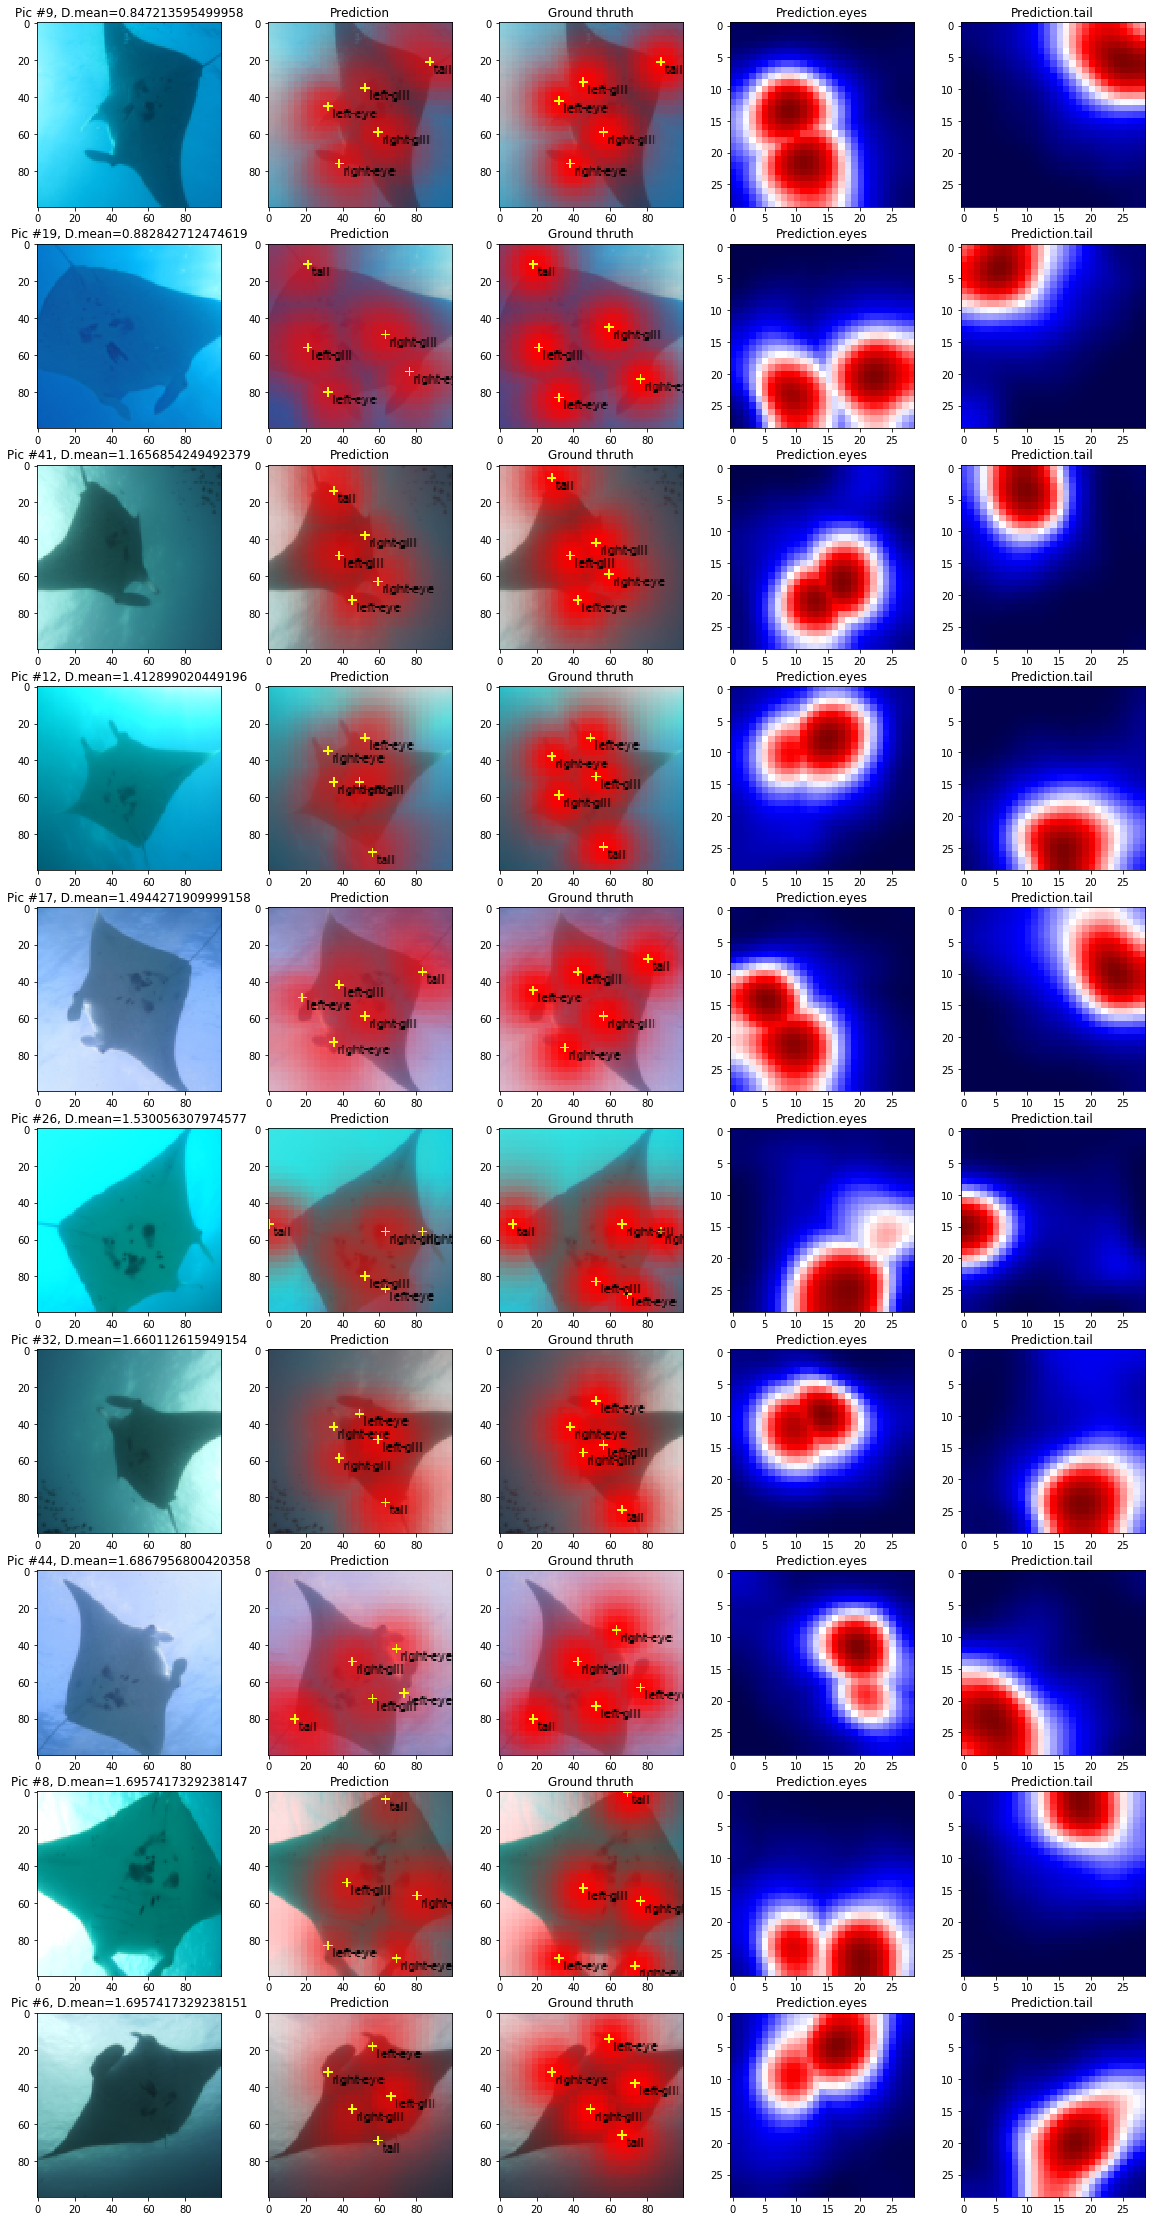

In [40]:
#best 5
qty=10

fig, axes = plt.subplots(nrows=qty, ncols=5,figsize=(20, 40))
for i,s in zip(range(qty),rating[:qty]):
    axes[i,0].imshow((pics_test[s]))
    axes[i,0].set_title("Pic #"+str(samples[i])+", D.mean="+str(distances.error[s]))
    
    axes[i,1].imshow(mfp.apply_heatmaps((pics_test[s]),smoothed[s]))
    axes[i,1].set_title('Prediction')
    
    axes[i,2].imshow(mfp.apply_heatmaps((pics_test[s]),y_test[s]))
    axes[i,2].set_title('Ground thruth')
    hm=smooth_heatmap(pred[s],2)
    
    axes[i,3].imshow(hm[:,:,:2].max(axis=2),cmap='seismic')
    axes[i,3].set_title('Prediction.eyes')
    
    axes[i,4].imshow(hm[:,:,4],cmap='seismic')
    axes[i,4].set_title('Prediction.tail')
    
    

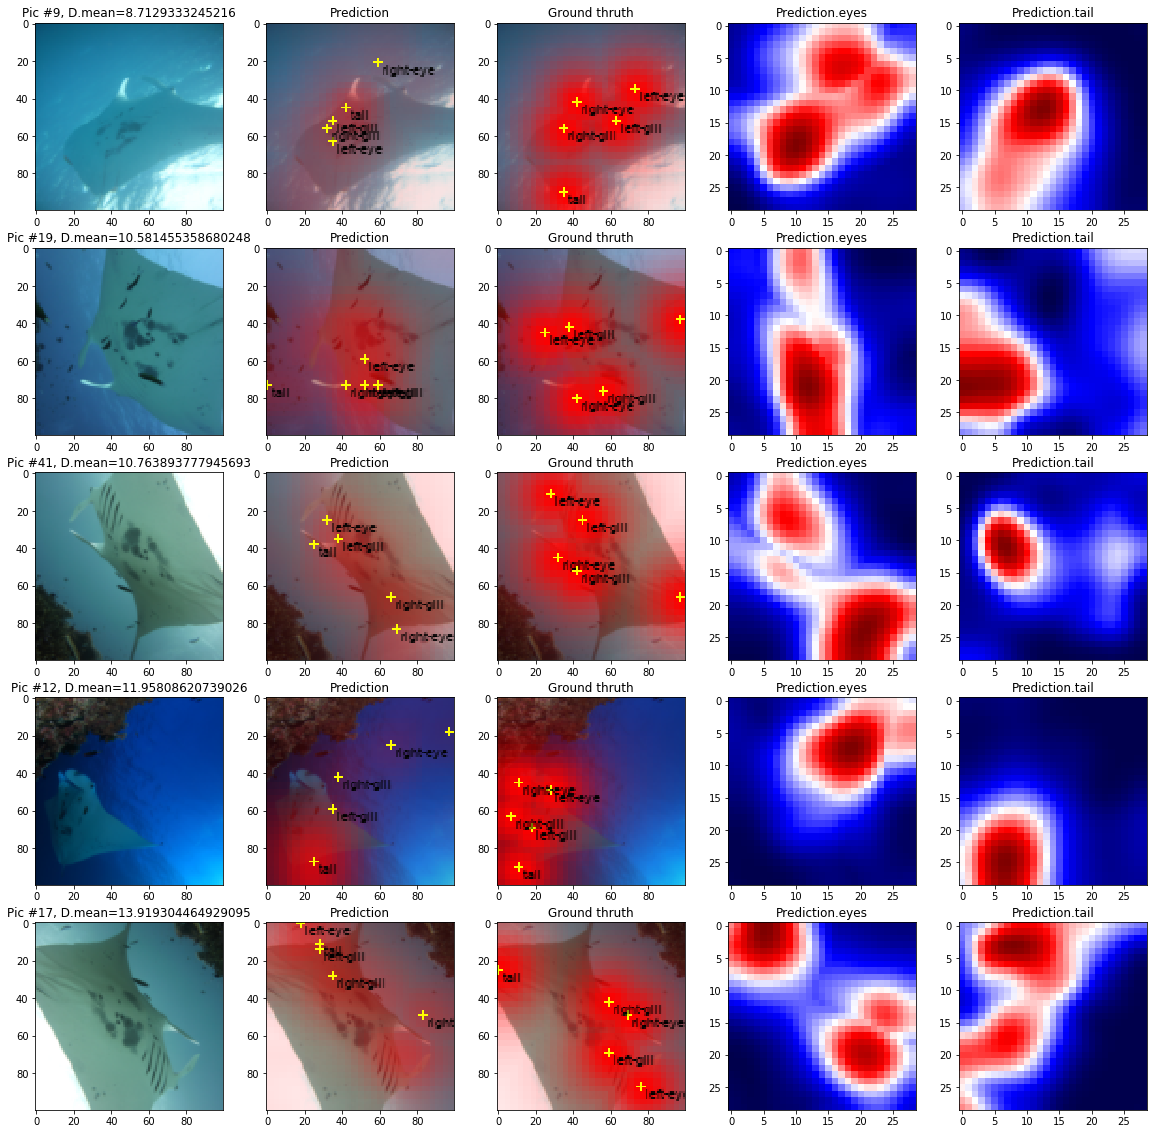

In [41]:
#worst 5
qty=5

fig, axes = plt.subplots(nrows=qty, ncols=5,figsize=(20, 20))
for i,s in zip(range(qty),rating[-qty:]):
    axes[i,0].imshow((pics_test[s]))
    axes[i,0].set_title("Pic #"+str(samples[i])+", D.mean="+str(distances.error[s]))
    
    axes[i,1].imshow(mfp.apply_heatmaps((pics_test[s]),smoothed[s]))
    axes[i,1].set_title('Prediction')
    
    axes[i,2].imshow(mfp.apply_heatmaps((pics_test[s]),y_test[s]))
    axes[i,2].set_title('Ground thruth')
    hm=smooth_heatmap(pred[s],2)
    
    axes[i,3].imshow(hm[:,:,:2].max(axis=2),cmap='seismic')
    axes[i,3].set_title('Prediction.eyes')
    
    axes[i,4].imshow(hm[:,:,4],cmap='seismic')
    axes[i,4].set_title('Prediction.tail')

In [ ]:
model.save('model_final_19_05_27.h5')

In [43]:
unknown=dataset[dataset.body_landmark_path.isnull()].image_path
unknown=np.array(unknown)
test=random.sample(list(unknown),20)

unknown_test=[]
unknown_images=[]
normalized=[]
for f in test:
    #print(f)
    img=Image.open(f)
    im_np=(mfp.to_np(img,image_size=image_size))
    normalized.append(mfp.normalize(im_np[:,:,:3]))
    unknown_images.append(im_np[:,:,:3])

normalized=np.array(normalized)
#print(normalized.shape)
X_unknown=feature_extractor.predict(np.array(normalized))

unknown_images=np.array(unknown_images)
print(unknown_images.shape)
print(X_unknown.shape)

(20, 100, 100, 3)
(20, 6, 6, 512)


In [44]:
unknown_heatmaps=model.predict(X_unknown)
smoo_unk=np.array([smooth_heatmap(h) for h in unknown_heatmaps])

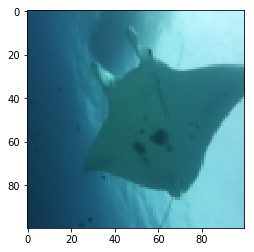

In [45]:
plt.imshow(unknown_images[4])

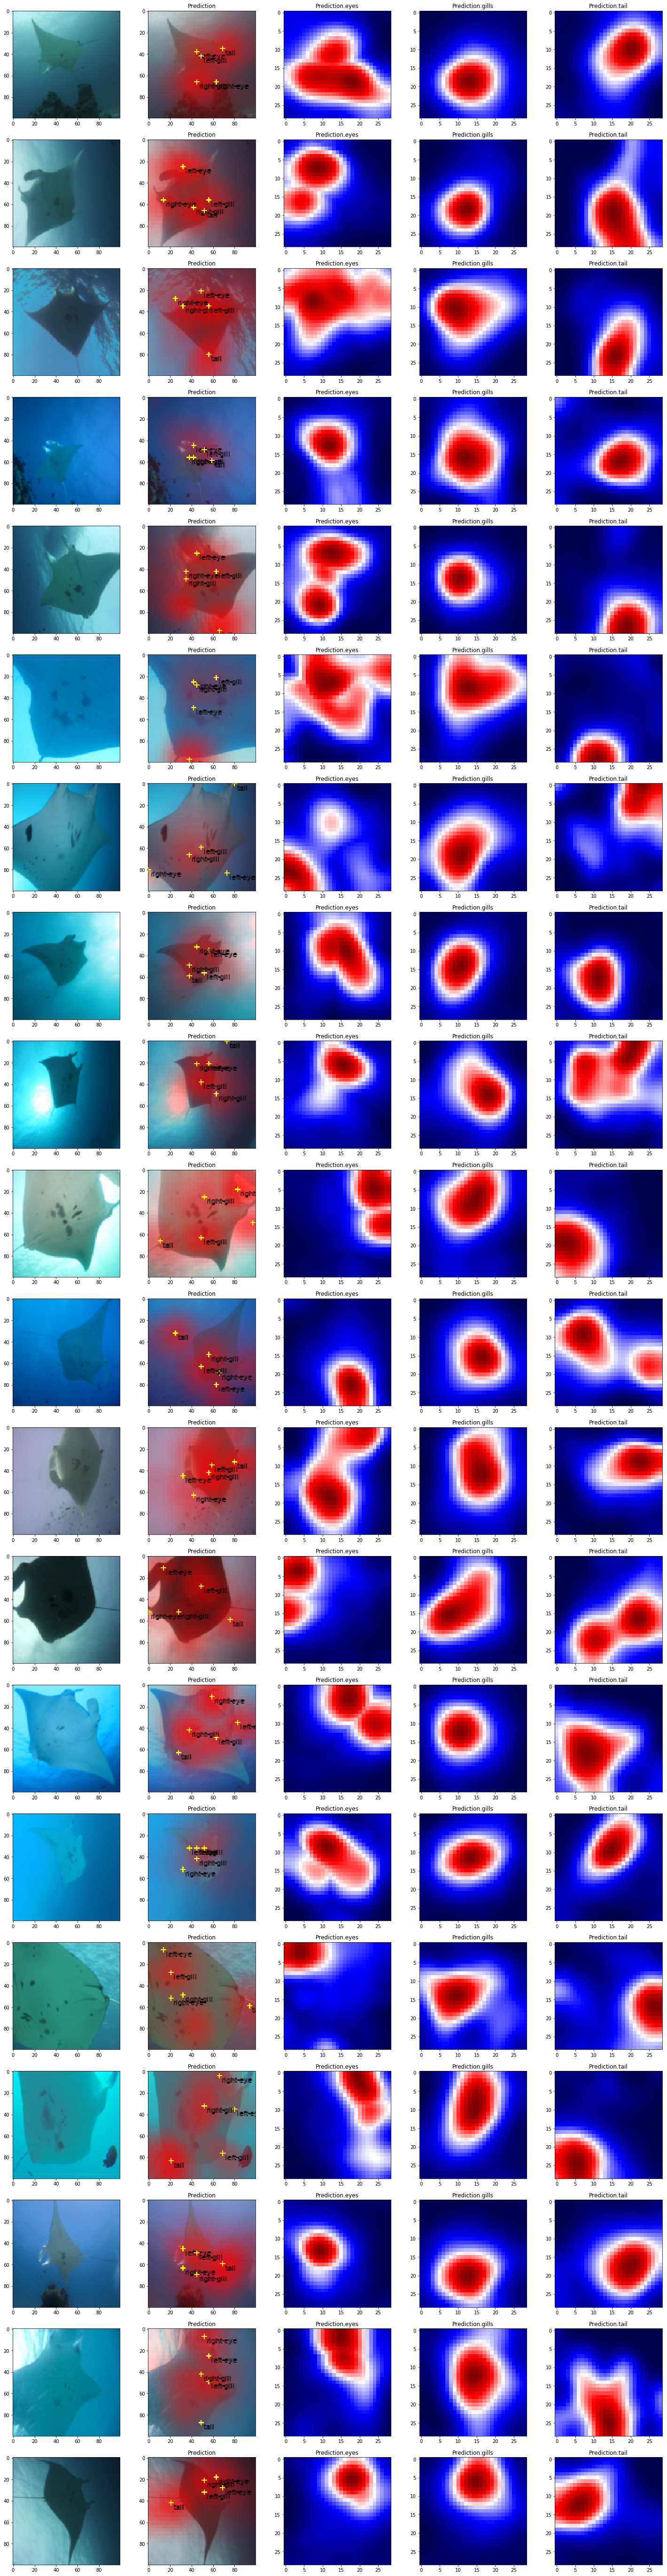

In [46]:
fig, axes = plt.subplots(nrows=20, ncols=5,figsize=(25, 100))
for i,im,h in zip(range(20),unknown_images,smoo_unk):
    axes[i,0].imshow(im)
    #axes[i,0].set_title("Pic #"+str(samples[i])+", D.mean="+str(distances[samples[i]]))
    
    axes[i,1].imshow(mfp.apply_heatmaps(im,h))
    axes[i,1].set_title('Prediction')
    
    #axes[i,2].imshow(mfp.apply_heatmaps(mfp.denormalize(pics_test[s]),y_test[s]))
    #axes[i,2].set_title('Ground thruth')
    #hm=smooth_heatmap(pred[s],2)
    
    axes[i,2].imshow(h[:,:,:2].max(axis=2),cmap='seismic')
    axes[i,2].set_title('Prediction.eyes')
    
    axes[i,3].imshow(h[:,:,3:4].max(axis=2),cmap='seismic')
    axes[i,3].set_title('Prediction.gills')
    
    axes[i,4].imshow(h[:,:,4],cmap='seismic')
    axes[i,4].set_title('Prediction.tail')


plt.show()


In [47]:
#tf.data.dataset

NameError: name 'tf' is not defined

In [ ]:
Backlog:
    -rotation
    -stratification for testing
    -separate test data
    -paper
    -sparate val data



Updates
week11 17.5.19:
    -data validation and test - separate subsets
    -blm qty control

week10 10.05.2019:
    - random angle rotation
    -Image Generator
    -Random zooming(cropping of original Image)
    -multi processing data generation
    -Dataset Issues detected (Exif information - rotation)
    -Labelling

week9 03.05.2019
    -unification of heatmaps
    -Cropping function
    -zooming-in function
    -rotating function
    -found issues i the dataset (image and bodylandmarks mismatch)
    -labelling
    -completely new data generation

week7 11.04.2019:
    -left-right update
    -heatmaps: 
        sum -> max when visualizing
        plt -> PIL.Image
        Yellow cross
        cmap="seismic"
        Gauss Filter
        3dmap
    -Metric: 
        Heatmap Peaks
        Best and worst visualisation
    -Model:
        Deep Transpose2D. stride=1
        no MaxPooling
        MSE instead of Binary crossentropy
        early stopping callback
        
Questions:
    size of 3d heatmap
    overfitting!!!!!!!!!!!!!!!!!!!!1
    save from plt.figure
    
plans:
    Keras data augmentation - no flips:
        90 angles * 3
        zoom in
        crop original image
        linear instead of sigmoid
        labelling
        try other pre-trained models?
        
    

In [ ]:
import multiprocessing as mp
from data_gen_process import image_heatmap_worker
import numpy as np
 
from arrayqueues.arrayqueues.shared_arrays import ArrayQueue


In [ ]:
%%time
batch_data=np.load("mant.npy")
print (batch_data.shape)

heatmap_order=("left-eye","right-eye","left-gill","right-gill","tail")
image_size=[100]*2
heatmap_size=[29]*2
params=(image_size,heatmap_size,heatmap_order)

q1=mp.Queue()

for i,b in enumerate(batch_data):
    q1.put((i,list(b)))
    
log=mp.Queue()
log.put("start")

#print("check q1",*q1.get())
try:
    del(q2)
    del(q3)
except: pass
q2 =ArrayQueue(10)
q2.clear()

q3 =ArrayQueue(10)
q3.clear()

l=mp.Lock()

print("spawning processes")
mypool=[]
for i in range(6):
    p = mp.Process(target=image_heatmap_worker, args=(q1,q2,q3,l,log,params))
    p.daemon=True
    p.start()
    mypool.append(p)

for p in mypool:
    p.join()


log.put("end")

print("joined.extract")

images=[]
heatmaps=[]

#print log
while True:
    try:
        l=log.get_nowait()
    except:break
    print(l)


while True:
    try:
        im=q2.get(timeout=0.5)  
        hm=q3.get(timeout=0.5)  
    except:break
    images.append(im)
    heatmaps.append(hm)
    
images=np.array(images)
heatmaps=np.array(heatmaps)
print(images.shape,heatmaps.shape)
print("======")    

In [ ]:
i=6
plt.imshow(mfp.apply_heatmaps(mfp.denormalize(images[i]),heatmaps[i]))